In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import librosa
import soundfile as sf
import librosa.display
import wave
import IPython.display as ipd
import os
import random

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, learning_curve


In [4]:

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchview import draw_graph

from pathlib import Path
import torchaudio

import random 
SEED = 42
def seed_everything(seed=42): 
    random.seed(seed) 
    os.environ['PYTHONHASHSEED'] = str(seed) 
    np.random.seed(seed) 
seed_everything(SEED)

In [5]:
from config import TARGET_CLASSES
data = "../esc-50/audio/audio/44100/"
dataset = pd.read_csv('../esc-50/esc50.csv')
dataset = dataset[dataset['category'].isin(TARGET_CLASSES)]
all_files = []
for _, row in dataset.iterrows():
    file_path = os.path.join(data, row["filename"])
    all_files.append(file_path)

In [6]:
decoder = {0: 'crackling_fire', 
           1: 'rain', 
           2: 'crying_baby', 
           3: 'door_wood_knock', 
           4: 'door_wood_creaks', 
           5: 'glass_breaking', 
           6: 'siren', 
           7: 'clock_alarm', 
           8: 'dog', 
           9: 'cat'}

encoder = {'crackling_fire': 0,
    'rain': 1,
    'crying_baby': 2,
    'door_wood_knock': 3,
    'door_wood_creaks': 4,
    'glass_breaking': 5,
    'siren': 6,
    'clock_alarm': 7,
    'dog': 8,
    'cat': 9}

##### Exploring the audio data

In [7]:
import config
audios_numpy = []
for file in all_files:
    audio, sr = librosa.load(file, sr=config.SAMPLE_RATE)
    audios_numpy.append(audio)


print('audio:', audio, '\n')
print('audio shape: ', np.shape(audio), '\n')
print('Sample Rate (KHZ): ', sr, '\n')

print(f'Duration of the audio: {np.shape(audio)[0]/sr} seconds')


audio: [-0.00015722 -0.00057978 -0.00057775 ...  0.          0.
  0.        ] 

audio shape:  (80000,) 

Sample Rate (KHZ):  16000 

Duration of the audio: 5.0 seconds


In [8]:
ipd.Audio(audios_numpy[20], rate=config.SAMPLE_RATE)



In [9]:
audios_numpy[1].shape

(80000,)

##### Distribution of category

In [10]:
category_group = dataset['category'].value_counts()
# plot = category_group.plot(kind='bar', title="Number of Audio Samples per Category", figsize=(30,30))
# plot.set_xlabel("Category")
# plot.set_ylabel("Number of Samples");
print(category_group)

category
dog                 40
door_wood_knock     40
clock_alarm         40
crackling_fire      40
rain                40
crying_baby         40
glass_breaking      40
siren               40
cat                 40
door_wood_creaks    40
Name: count, dtype: int64


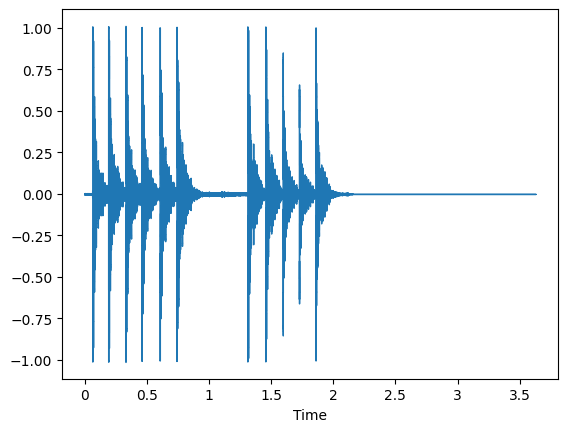

In [11]:
librosa.display.waveshow(audios_numpy[1])

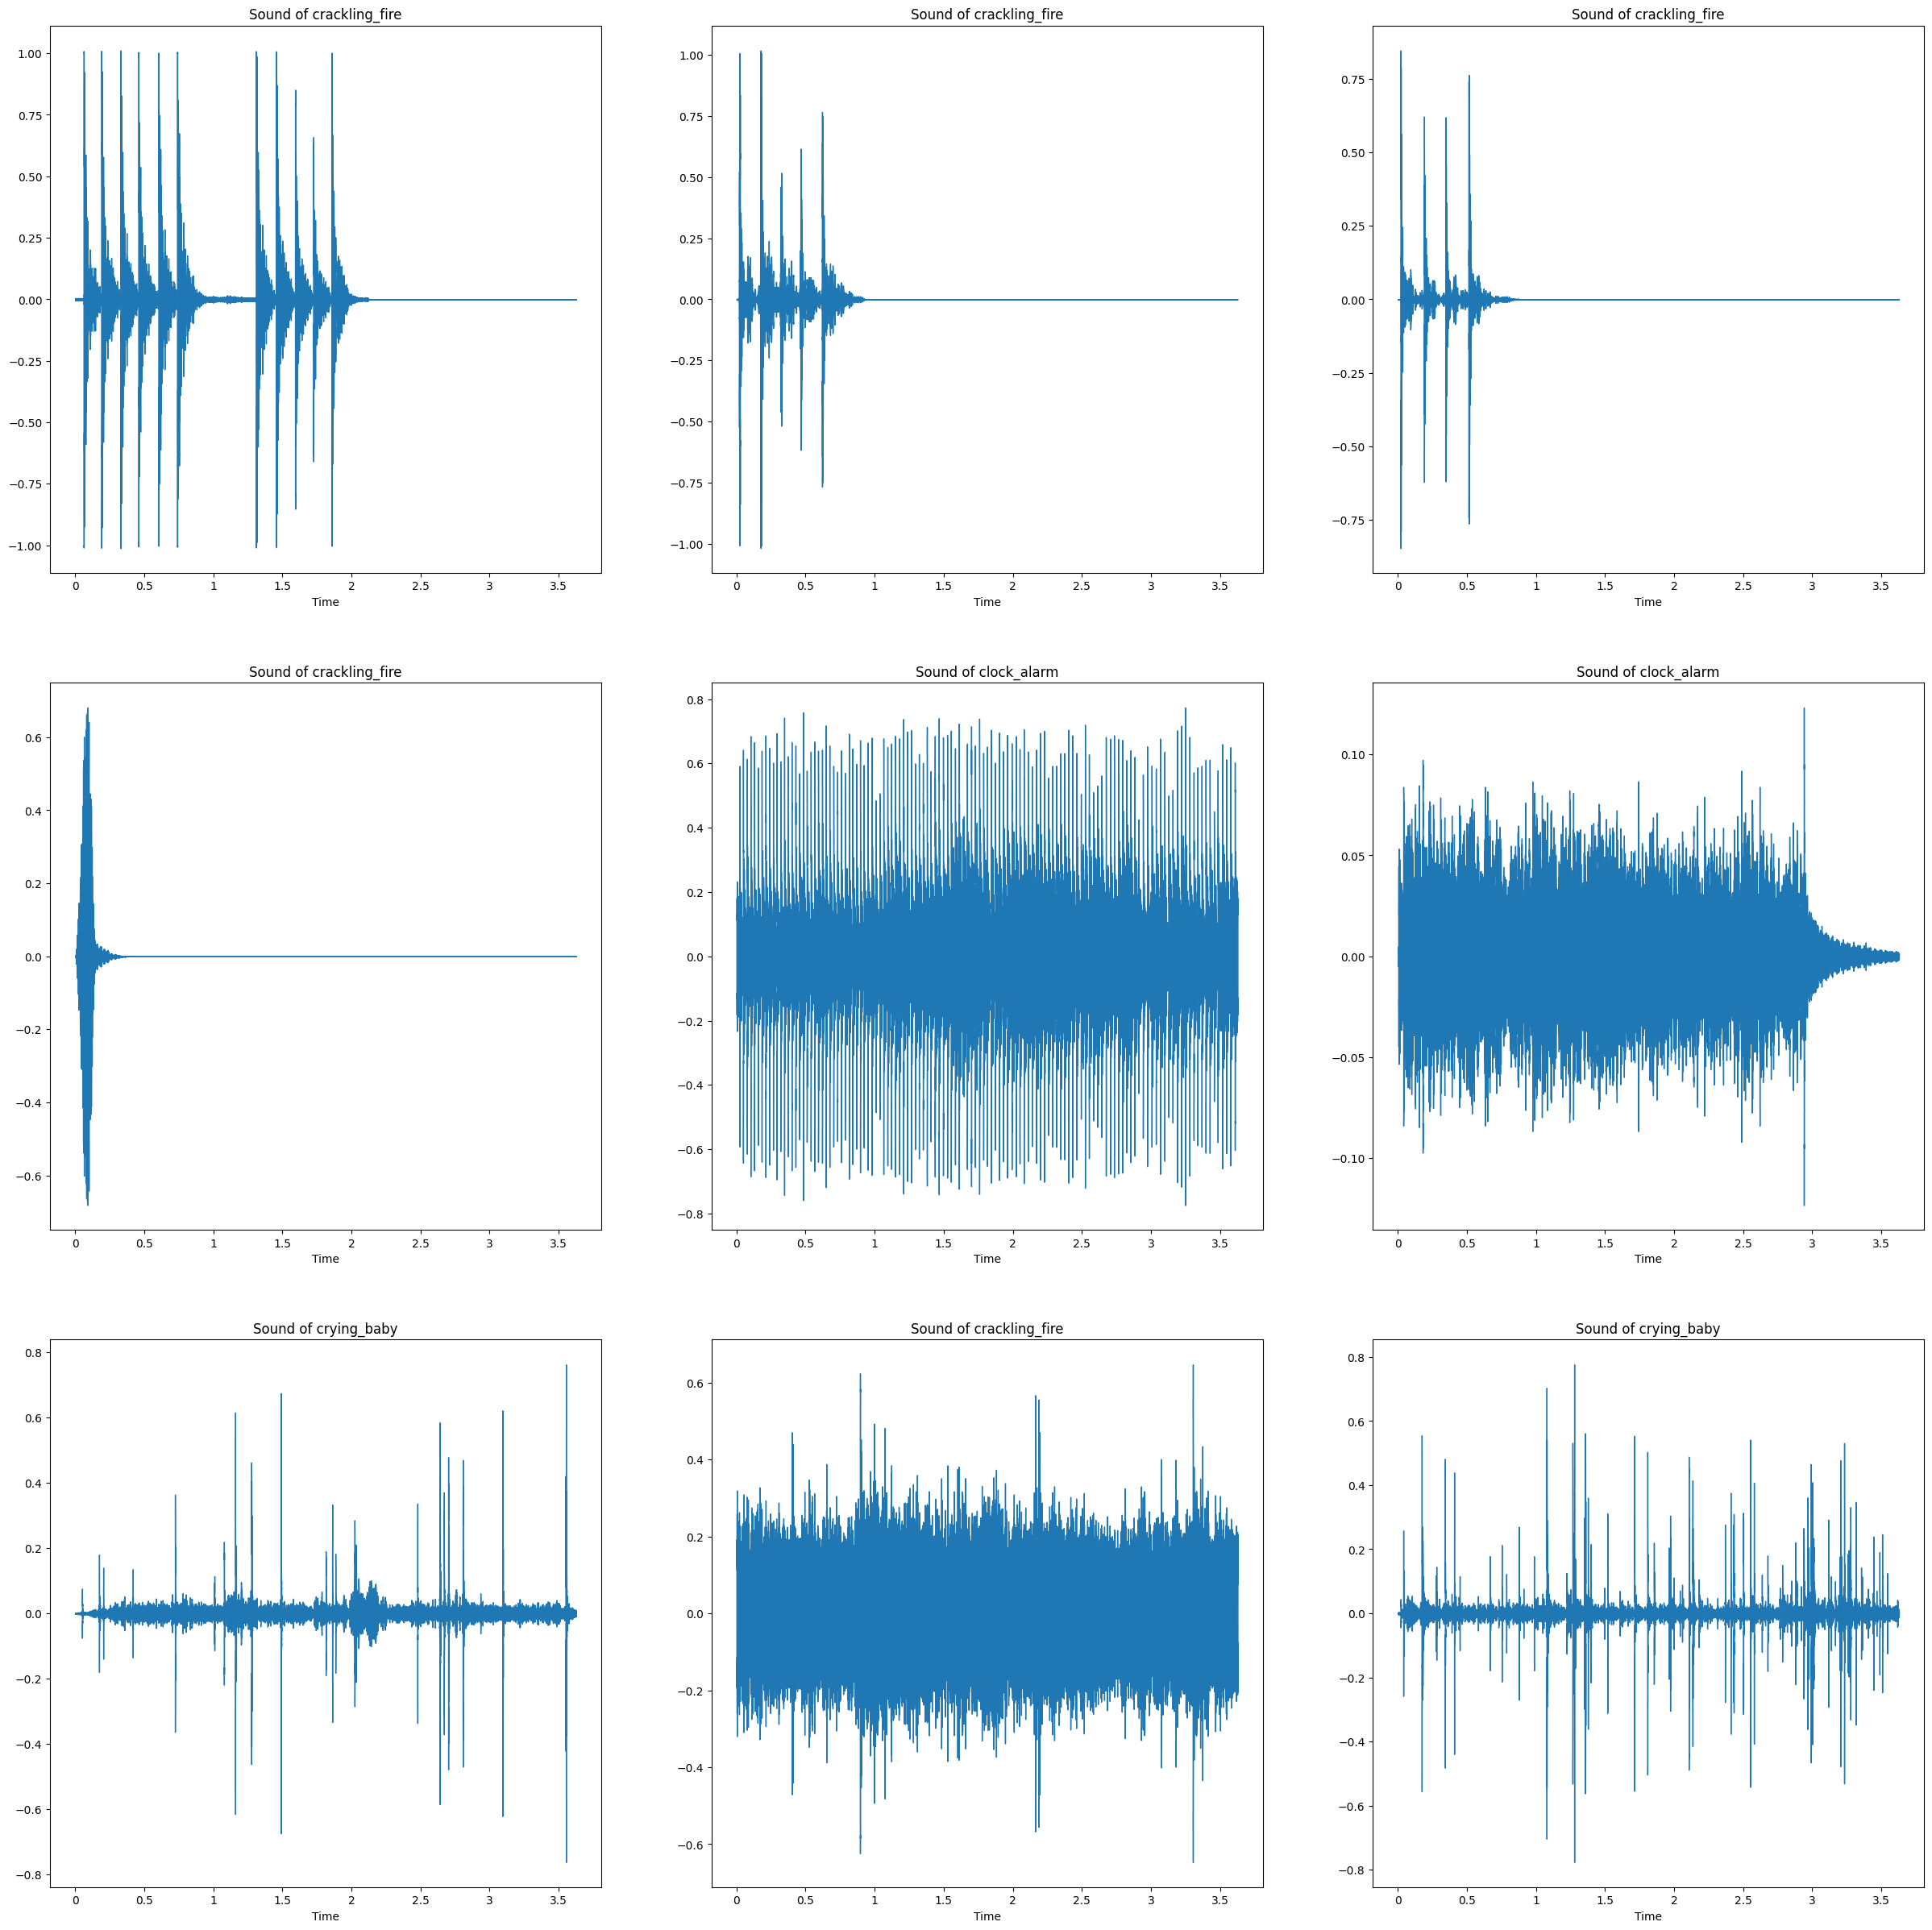

In [12]:
plt.figure(figsize=(30,30))
for i in range(1,10):
    plt.subplot(3,3,i)
    librosa.display.waveshow(audios_numpy[i])
    try:
        plt.title("Sound of " + decoder[int(all_files[i][-6:-4])] )
    except:
        plt.title("Sound of " + decoder[int(all_files[i][-5:-4])] )

##### Visualization of Audio: Fourier Transformation

In [13]:
import config
n_fft = config.N_FFT
hop_length = config.HOP_LENGTH

ffts = []
for i in range(len(all_files)):
    FFT = np.abs(librosa.stft(audios_numpy[i], n_fft= n_fft, hop_length= hop_length))
    ffts.append(FFT)
# plt.figure(figsize=(30,30))
# for i in range(1,10):
#     plt.subplot(3,3,i)
#     X = np.abs(librosa.stft(all_files[i], n_fft = n_fft, hop_length = hop_length))
#     plt.plot(X)
#     plt.xlabel("Frequency")
#     plt.ylabel("Amplitude");
#     try:
#         plt.title("Fourier Transform of the sound of " + decoder[int(all_files[i][-6:-4])] )
#     except:
#         plt.title("Fourier Transform of the sound of " + decoder[int(all_files[i][-5:-4])] )

Text(0, 0.5, 'Amplitude')

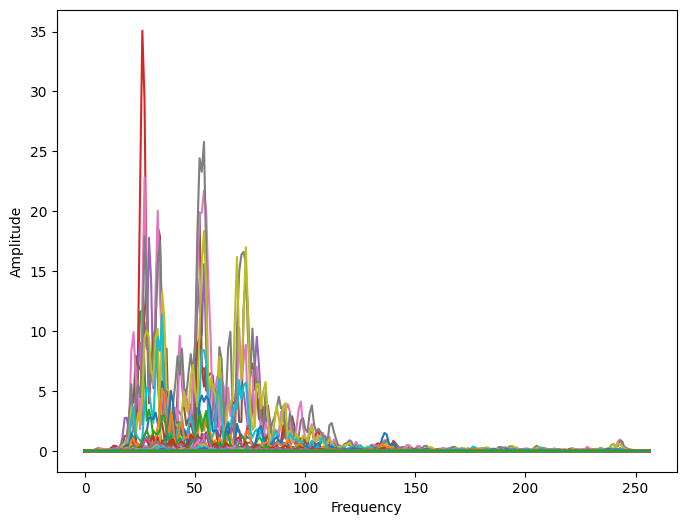

In [14]:
plt.figure(figsize=(8, 6))
plt.plot(ffts[0])
plt.xlabel("Frequency")
plt.ylabel("Amplitude")




In [15]:
import config
mfccs = []
for i in range(len(all_files)):
    MFCC = librosa.feature.mfcc(y = audios_numpy[i], sr= config.SAMPLE_RATE)
    mfccs.append(MFCC)

# plt.figure(figsize=(30,30))
# for i in range(1,10):
#     plt.subplot(3,3,i)
#     mfccs = librosa.feature.mfcc(y=y, sr=sr)
#     librosa.display.specshow(mfccs, sr=plot_audios[i][1], x_axis='time')
#     try:
#         plt.title("Sound of " + decoder[int(plot_files[i][-6:-4])] )
#     except:
#         plt.title("Sound of " + decoder[int(plot_files[i][-5:-4])] )

In [16]:
(np.array(audios_numpy)).shape

(400, 80000)

In [21]:
mfccs = np.array(mfccs)
mfccs = mfccs[:, None, :, :]

mfccs.shape

(400, 1, 20, 157)

###### Normalization of mfccs

In [20]:
mean = mfccs.mean()
std = mfccs.std()
mfccs = (mfccs - mean) / std